# Reliability diagrams

In [1]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict
from reliability_diagrams import *

## Load the data

The results are stored in a CSV file with 3 columns: `true_label`, `pred_label`, `confidence`. For a multi-class model, the predicted label and the confidence are for the highest-scoring class.

In [2]:
csv_dir = "./results"

In [3]:
datasets = sorted(os.listdir(csv_dir))
datasets

['ImageNet_pytorch-image-models', 'ImageNet_torchvision', 'markus93', 'other']

In [4]:
files = {}
for dataset in datasets:
    path = os.path.join(csv_dir, dataset)
    filenames = [x for x in sorted(os.listdir(path)) if x[-4:] == ".csv"]
    files[dataset] = filenames

In [5]:
files

{'ImageNet_pytorch-image-models': ['densenetblur121d.csv',
  'efficientnet_b1.csv',
  'efficientnet_b3a.csv',
  'ese_vovnet19b_dw.csv',
  'gluon_senet154.csv',
  'mixnet_m.csv',
  'mobilenetv3_large_100.csv',
  'resnet34.csv',
  'resnext50_32x4d.csv',
  'tf_inception_v3.csv'],
 'ImageNet_torchvision': ['densenet161.csv',
  'inception_v3.csv',
  'resnet101.csv',
  'resnext101_32x8d.csv'],
 'markus93': ['probs_densenet40_c100_logits.csv',
  'probs_densenet40_c10_logits.csv',
  'probs_resnet110_c100_logits.csv',
  'probs_resnet110_c10_logits.csv',
  'probs_resnet50_birds_logits.csv'],
 'other': ['snacks.csv']}

## Look at the results for a single model

In [6]:
dataset = "ImageNet_pytorch-image-models"
filename = files[dataset][4]
filename

'gluon_senet154.csv'

In [7]:
dataset = "markus93"
filename = files[dataset][1]
filename

'probs_densenet40_c10_logits.csv'

In [8]:
dataset = "other"
filename = files[dataset][0]
filename

'snacks.csv'

In [9]:
dataset = "ImageNet_torchvision"
filename = files[dataset][3]
filename

'resnext101_32x8d.csv'

In [10]:
df = pd.read_csv(os.path.join(csv_dir, dataset, filename))
plot_name = filename[:-4] + " " + dataset

In [11]:
df.head()

,true_label,pred_label,confidence
0,0,394,0.725356
1,0,0,0.995511
2,0,0,0.761057
3,0,0,0.999909
4,0,0,0.999999


In [12]:
# Should equal the number of test examples.
len(df)

50000

In [13]:
# Sanity check: compute top-1 accuracy.
(df.true_label == df.pred_label).sum() / len(df)

0.79312

In [14]:
df.confidence.mean()

0.8737401799026132

In [15]:
y_true = df.true_label.values
y_pred = df.pred_label.values
y_conf = df.confidence.values

## Make the plot

In [16]:
# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

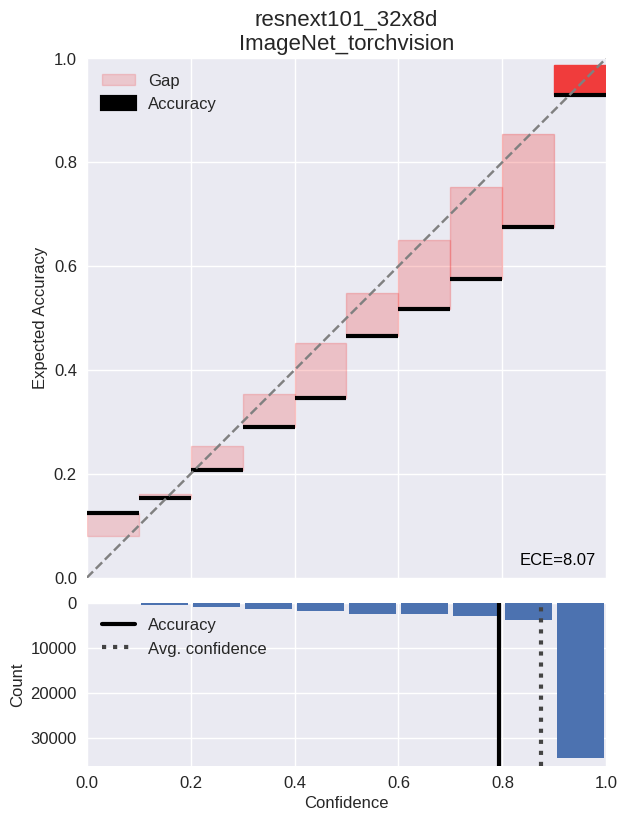

In [17]:
title = "\n".join(plot_name.split())

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)

In [15]:
fig.savefig("figures/" + "_".join(plot_name.split()) + ".png", 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2)

## Look at the bins

In [18]:
bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins=20)

In [19]:
bin_data

{'accuracies': array([0.        , 0.13513514, 0.09322034, 0.18145161, 0.1915493 ,
        0.21902655, 0.26352531, 0.31295488, 0.32415519, 0.36689038,
        0.4511811 , 0.47927032, 0.50490998, 0.52911814, 0.53363229,
        0.6132522 , 0.66180935, 0.68477729, 0.75868852, 0.94486407]),
 'confidences': array([0.03671529, 0.08362046, 0.12840304, 0.17743247, 0.22581327,
        0.27675361, 0.32623369, 0.37612867, 0.42549591, 0.47600087,
        0.52500019, 0.57431767, 0.62473106, 0.67551116, 0.72557938,
        0.77448004, 0.82619679, 0.8760866 , 0.92769473, 0.99363996]),
 'counts': array([    3,    37,   118,   248,   355,   452,   573,   687,   799,
          894,  1270,  1206,  1222,  1202,  1338,  1479,  1647,  2043,
         3050, 31377]),
 'bins': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'avg_accuracy': 0.79312,
 'avg_confidence': 0.8737401799026132,
 'expected_calibration_error':

## Plot reliability diagrams for all models

In [20]:
def read_results(csv_dir, dataset, filename):
    df = pd.read_csv(os.path.join(csv_dir, dataset, filename))

    y_true = df.true_label.values
    y_pred = df.pred_label.values
    y_conf = df.confidence.values

    plot_name = filename[:-4] + " " + dataset
    return plot_name, { "true_labels": y_true,
                        "pred_labels": y_pred,
                        "confidences": y_conf}

In [21]:
results = OrderedDict()
for dataset, filenames in files.items():
    for filename in filenames:
        plot_name, data = read_results(csv_dir, dataset, filename)
        results[plot_name] = data

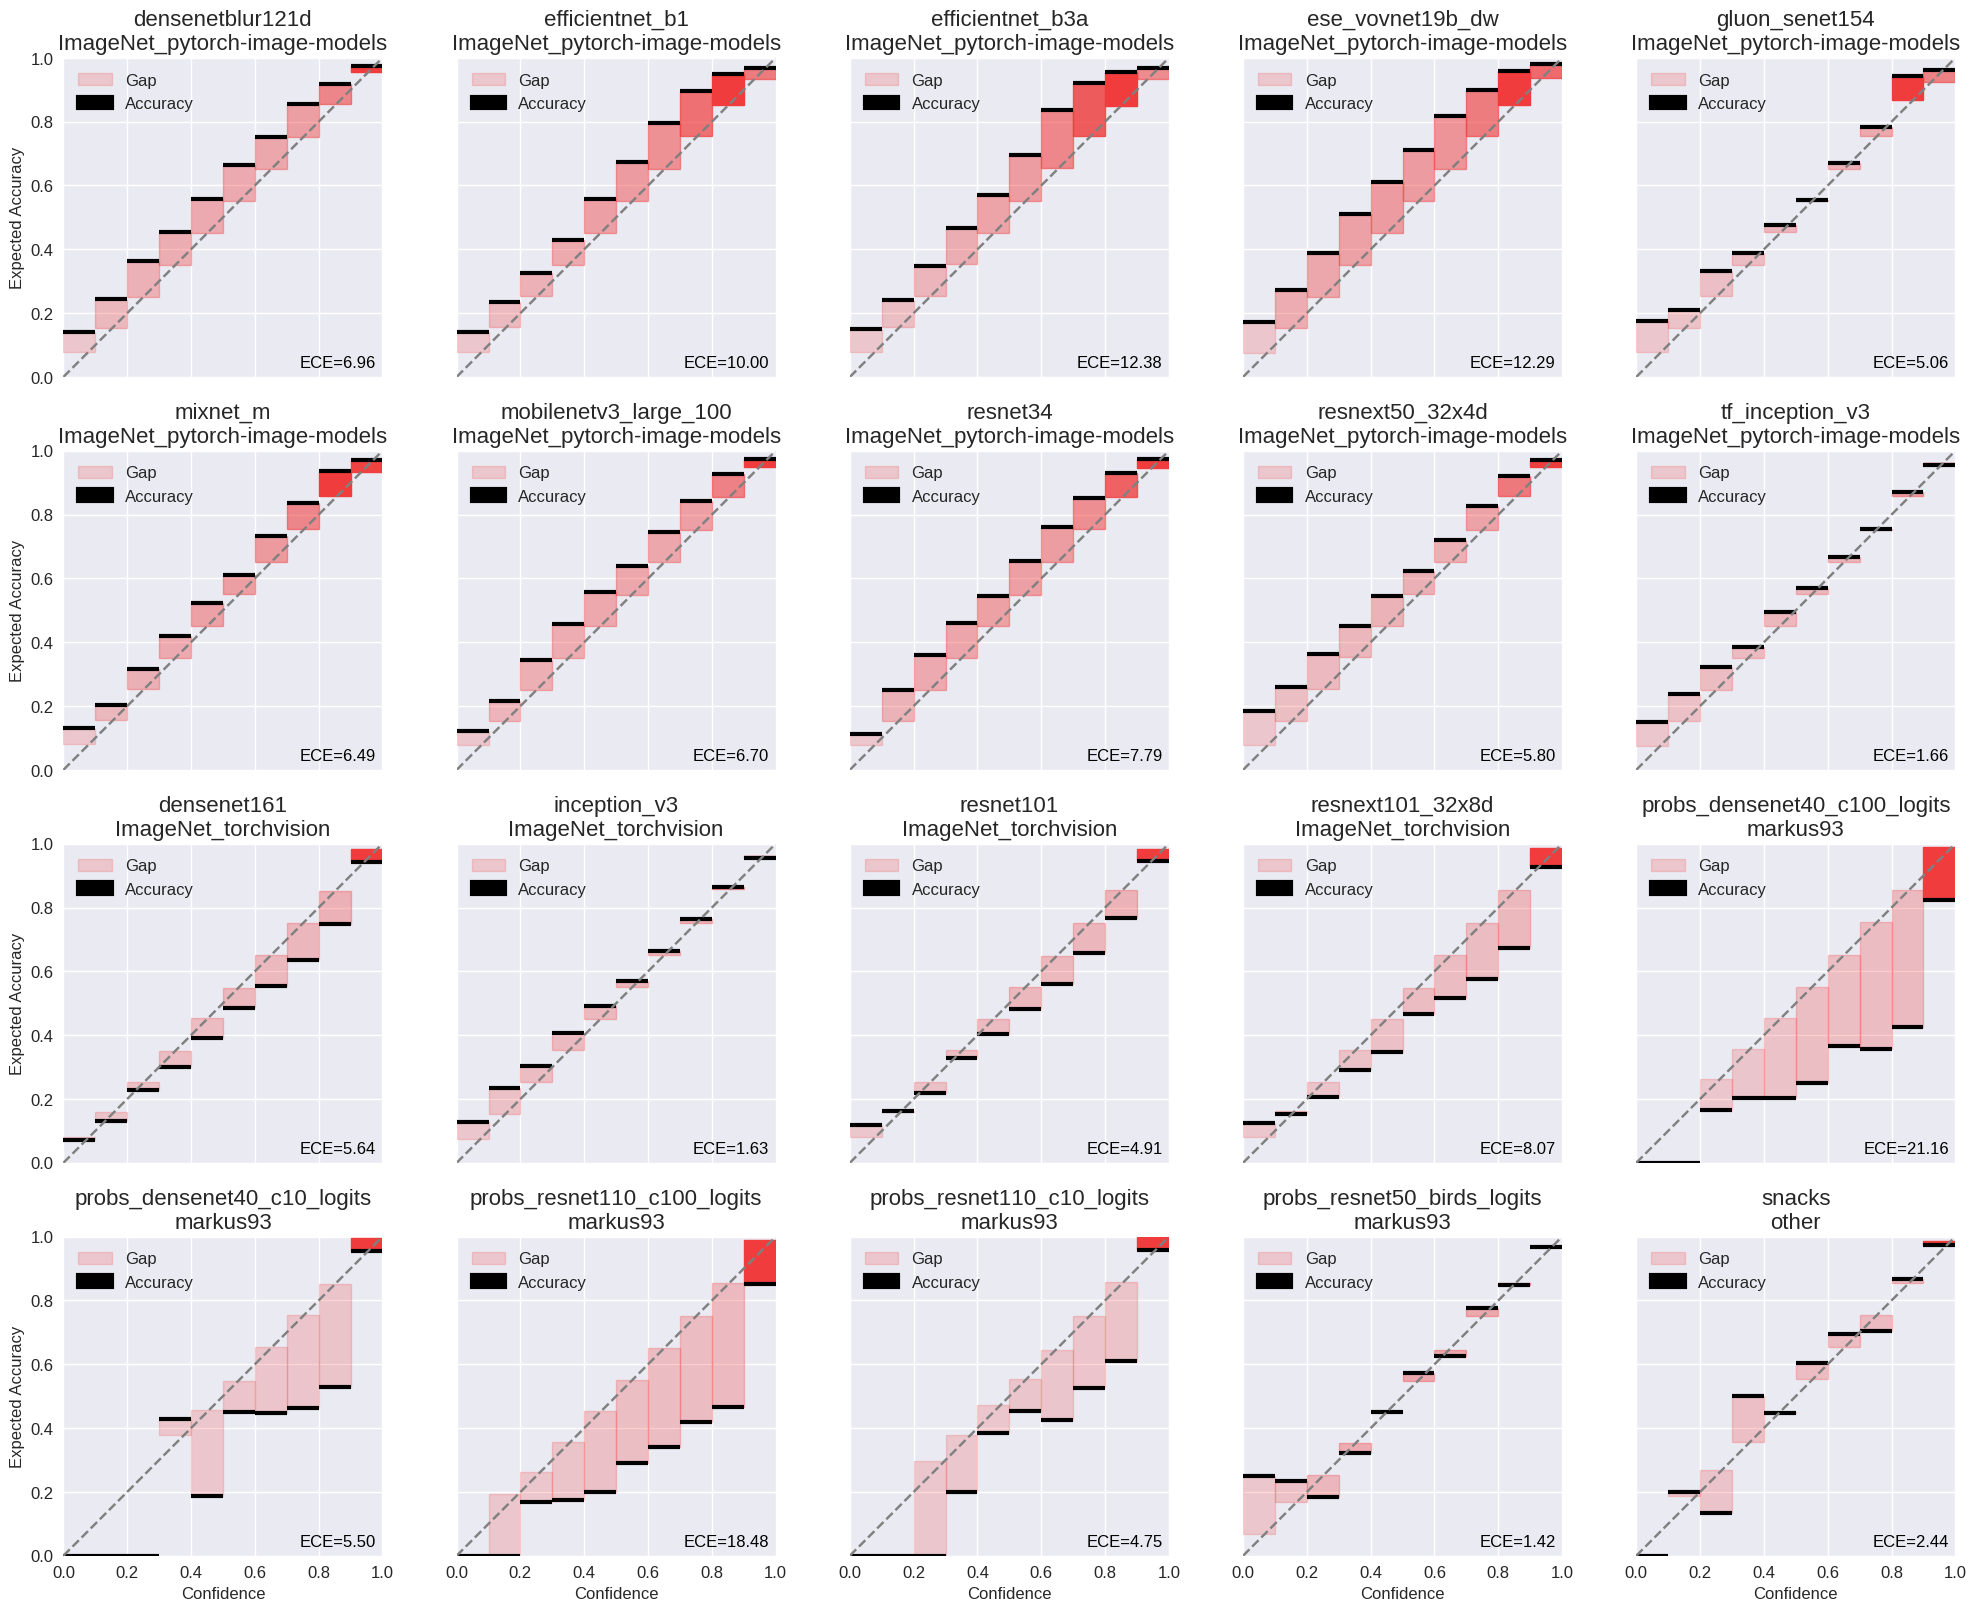

In [22]:
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=5, dpi=100, return_fig=True)

In [23]:
fig.savefig("figures/all.png", format="png", dpi=144, bbox_inches="tight", pad_inches=0.2)

In [ ]:
# TODO: maybe draw a separate graph per subdir?